<a href="https://colab.research.google.com/github/ArghaSarker/reinforcement-learning-homework-summer-2023/blob/main/homework02/homework02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implementation
General information:
- number of states is set by world size - number of wall tiles
- amount of trap tiles and wall tiles can be customized
- 4 actions: up, down, left, right
- 2 end states (good/bad) -> good state is goal state
- static/non-probabilisitc rewards: non-special tile (-1), trap tile (-50), bad end (-100), good end (+100) 
  - probabilistic state transition function: chosen action (p=0.7), unwanted action (each p=0.1)
- when **_choosing_** an action, we automatically **exclude impossible actions** (i.e. actions against world boundary or wall tile). However, when **_conducting_** an action with probabilistic state transition function, the agent could do **any actions** with a certain probability (i.e. **also impossible ones** -> agent runs into boundary/wall and therefore stays in current tile)


Complexities to overcome:
- avoid running into wall (non-passible tile + world boundary)
- avoid running into trap (penalizing tile)
- avoid bad end (penalizing tile)
- choose good end (rewarding tile)
- terminate as quickly as possible (each step to non-special tile is penalized)

Default Grid World:
- 12 tiles - 11 accessible / 1 unacessible (wall)
- 11 states: {(0,0),(1,0),(2,0),(0,1),(2,1),(0,2),(1,2),(2,2),(0,3),(1,3),(2,3)}
  - 4 special states: 2 end states (good/bad), 1 trap state

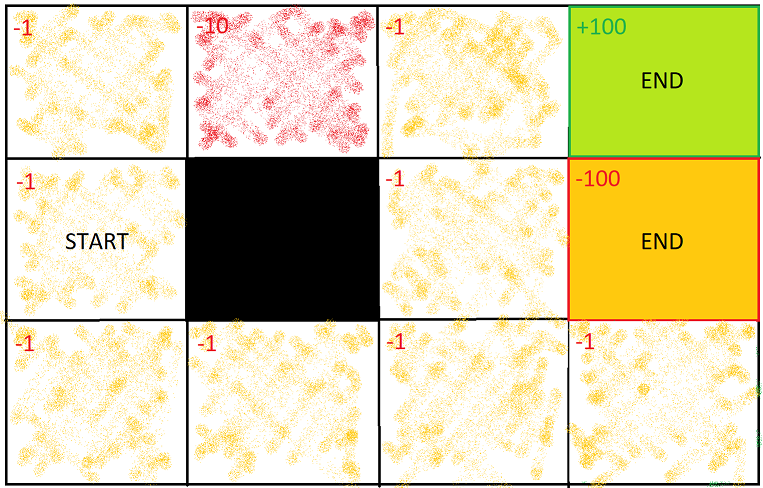

In [1]:
import time
import math
import random
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
class GridWorld:

  def __init__(self, n_rows=3, n_cols=4, win_state=(0,3), lose_state=(1,3), walls=[(1,1)], traps=[(0,1)], start=(1,0)):
    """
      Creates a grid world of 
        - (n_rows x n_cols)- len(wall) states 
        - len(walls) non-passable wall tiles
        - len(traps) trap tiles that penalize
        - 2 goal states (good=win_state, bad=lose_state) that end current episode and reset environment
      Sets start position of agent (start) 
    """
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.win_state = win_state
    self.lose_state = lose_state
    self.walls = walls
    self.traps = traps
    self.start = start
    self.pos_agent = start
  

  def get_actions(self,state):
    """
      Checks if actions in a state are restricted and returns list of all possible actions
      - impossible actions are marked as None-type
    """
    up = (-1,0)
    down = (1,0)
    left = (0,-1)
    right = (0,1)

    #check if agent is on boundary tile
    #upper boundary
    if state[0] == 0:
      #upper left corner
      if state[1] == 0:
        actions = [None,down,None,right]
      #upper right corner
      elif state[1] == self.n_cols-1:
        actions = [None,down,left,None]
      else:
        actions = [None,down,left,right]
    #lower boundary
    elif state[0] == self.n_rows-1:
      #lower left corner
      if state[1] == 0:
        actions = [up,None,None,right]
      #lower right corner
      elif state[1] == self.n_cols-1:
        actions = [up,None,left,None]
      else:
        actions = [up,None,left,right]
    #left boundary
    elif state[1] == 0:
      actions = [up,down,None,right]
    #right boundary
    elif state[1] == self.n_cols-1:
      actions = [up,down,left,None]
    #no boundary
    else:
      actions = [up,down,left,right]

    #check if agent is next to a wall tile
    for a_idx in range(4):
      if actions[a_idx] != None:
        new_state = tuple(sum(i) for i in zip(state, actions[a_idx]))
        if new_state in self.walls:
          #remove action towards wall tile
          actions[a_idx] = None

    #return possible actions
    return actions


  def init_policy(self):
    """
      Initializes the policy for all state-action pairs
      - None elements represent impossible actions (in respective state)
      - equal probability for all possible actions (in respective state)
      - actions for all states: [up,down,left,right]
    """
    policy = [[0 for column in range(self.n_cols)] for row in range(self.n_rows)]
    #iterate over all states
    for row in range(self.n_rows):
      for column in range(self.n_cols):
        state = (row,column)
        #get possible actions
        actions = self.get_actions(state)
        n_possible_actions = sum(1 for a in actions if a is not None)
        #equally distribute probability among possible actions
        policy[row][column] = [(1/n_possible_actions) if a is not None else None for a in actions]
    return policy


  def choose_action(self, state, policy):
    """
      Chooses an action randomly, given a policy
      - state = current state
      - policy = list of state-action pair probabilities
    """
    #get probability distribution for current state
    prob_dist = policy[state[0]][state[1]]
    #filter out impossible actions
    prob_dist_possible = [a for a in prob_dist if a is not None]
    #choose action randomly based on their probability
    idx = random.choices(range(len(prob_dist_possible)), weights=prob_dist_possible, k=1)[0]
    #map back to complete list of actions
    action_idx = idx
    for i,val in enumerate(prob_dist):
      if val is None:
        action_idx += 1
      if i == action_idx:
        break
    #get chosen action
    if action_idx == 0: #up
      action = (-1,0)
    elif action_idx == 1: #down
      action = (1,0)
    elif action_idx == 2: #left
      action = (0,-1)
    elif action_idx == 3: #right
      action = (0,1)
    else:
      raise Exception("Invalid action")
    #return chosen action
    return action


  def make_action(self,action):
    """
      Conducts action implicitly by changing agent's position
      - action = the chosen action
      - returns the state reached when taking the action
    """
    all_actions = [(-1,0),(1,0),(0,-1),(0,1)] #up,down,left,right
    #assign chosen action a probability of 0.7 (others p=0.1)
    probabilities = [0.7 if a == action else 0.1 for a in all_actions]
    #take action randomly based on their probability
    action = random.choices(all_actions, weights=probabilities, k=1)[0] 
    new_state = tuple(sum(i) for i in zip(self.pos_agent,action))
    #if agent runs into wall or world boundary
    if new_state in self.walls or new_state[0] < 0 or new_state[0] > self.n_rows-1 or new_state[1] < 0 or new_state[1] > self.n_cols-1:
      #stay in current position
      new_state = self.pos_agent
    #move agent to next state
    self.pos_agent = new_state
    return new_state
    

  def get_reward(self):
    """
      Add reward gained after taking an action
    """
    #check if action lead to good end tile
    if self.pos_agent == self.win_state:
      reward = 100
    #check if action lead to bad end tile
    elif self.pos_agent == self.lose_state:
      reward = -100
    #check if action lead to trap tile
    elif self.pos_agent in self.traps:
      reward = -50
    #action lead to non-special tile
    else:
      reward = -1
    #return reward
    return reward


  def game_over(self):
    """
      Returns True if end tile is reached and False if not
    """
    return self.pos_agent == self.win_state or self.pos_agent == self.lose_state


  def reset(self):
    """
      Resets the world to initialization
    """
    self.pos_agent = self.start
  

  def mc_control_with_epsilon_greedy_policies(self, n_episodes, epsilon_decay_rate, discount_factor=1.0, first_trial = True, parameters = None):
    """
      A MC policy iteration variant that computes a probability distribution over all possible actions based on ϵ-policy.
      Starting with high exploration (ϵ=1.0), then gradually decreasing ϵ and therefore increasing exploitation (until ϵ=0.0).
      - n_episodes = total number of episodes that are conducted (int) 
      - epsilon_decay_rate = the amount by which epsilon is decreased after each episode
      - discount_factor = the importance of future rewards relative to immediate rewards (1.0 = equal importance, ..., 0.0 = only direct reward)
      - first_trial (bool) = if false, then parameters (q-values,policy,epsilon,returns) are not initialized but inherited from previous run
      - parameters (if first_trial = false, then list): the starting values for ϵ-policy, q-values, epsilon, returns, list of rewards of each episode, average return-per-episode, time-per-episode
    """
    #INITIALIZATION (actions for each state: [up,down,left,right])
    if first_trial == True:
      policy = self.init_policy()                                                                         #equal probability for all possible actions in a state
      q_value = [[[None,None,None,None] for column in range(self.n_cols)] for row in range(self.n_rows)]  #expected value/return of state-action pair (init: None)
      epsilon = 1.0
      returns = [[[[],[],[],[]] for column in range(self.n_cols)] for row in range(self.n_rows)]          #stores all returns of all state-action pairs (init: empty)
      episodes_reward = []                                                                                #lists return of each episode (init: at episode 0, 0 return)
      avg_rpe = []                                                                                        #lists average return-per-episode (init: after 0 episodes, 0 return on average)
      time_per_episode = []                                                                               #lists wallclock time, i.e. time spend on total until current episode (whole policy iteration)
      #no previous time, as it is first run
      prev_time = 0
    else:
      policy,q_value,epsilon,returns,episodes_reward,avg_rpe,time_per_episode = parameters
      #save total time of previous run
      prev_time = time_per_episode[-1]
    
    #get start time
    start_time = time.time()

    #POLICY ITERATION
    for episode in range(n_episodes):
      episode_info = []  #stores all info of single episode (list representing sequence of (state,action,reward))

      #CONDUCT EPISODE
      #agent interacts with world until reaching end state
      while self.game_over() == False:
        #get current state
        state = self.pos_agent
        #choose action according to current policy
        action = self.choose_action(state,policy)
        #take action
        new_state = self.make_action(action)
        #receive reward
        reward = self.get_reward()
        #save state, action, and received reward
        episode_info.append((state,action,reward))
      #reset world when episode done
      self.reset()

      #POLICY EVALUATION
      #keep only the 1st occurrences of state-action pairs
      seen_items = {}
      for i, item in enumerate(episode_info):
        key = (item[0],item[1]) #use state-action pair as key
        if key in seen_items:
          seen_items[key] += 1
          if seen_items[key] > 1:
            episode_info[i] = (None,None,item[2]) #replace 2nd,3rd,... occurrences with None
        else:
          seen_items[key] = 1
      #initialize return
      G = 0
      #iterate over each step in the episode in reverse order
      for t in range(len(episode_info)-1, -1, -1):   
          #get the state, action and reward  
          state, action, reward = episode_info[t]      
          #add the reward to the total return
          G = discount_factor * G + reward    
          #if current state-action pair is a 1st occurrence         
          if state != None:                            
            #append return + update q-value to respective state-action pair
            if action == (-1,0): #up
              returns[state[0]][state[1]][0].append(G)
              q_value[state[0]][state[1]][0] = sum(returns[state[0]][state[1]][0]) / len(returns[state[0]][state[1]][0]) 
            elif action == (1,0): #down
              returns[state[0]][state[1]][1].append(G) 
              q_value[state[0]][state[1]][1] = sum(returns[state[0]][state[1]][1]) / len(returns[state[0]][state[1]][1]) 
            elif action == (0,-1): #left
              returns[state[0]][state[1]][2].append(G)
              q_value[state[0]][state[1]][2] = sum(returns[state[0]][state[1]][2]) / len(returns[state[0]][state[1]][2]) 
            elif action == (0,1): #right
              returns[state[0]][state[1]][3].append(G)
              q_value[state[0]][state[1]][3] = sum(returns[state[0]][state[1]][3]) / len(returns[state[0]][state[1]][3])
            else:
              raise Exception("Invalid action")

      #POLICY IMPROVEMENT
      #get all states visited
      visited_states = list({t[0] for t in episode_info if t[0] is not None})
      #for each visited state
      for state in visited_states:
        #get best action, i.e. action with highest q-value
        idx = q_value[state[0]][state[1]].index(max(filter(lambda x: x is not None, q_value[state[0]][state[1]])))
        #count number of possible actions
        n_possible_actions = len([x for x in policy[state[0]][state[1]] if x is not None])
        #get probability distribution over all possible actions of current state
        for a in range(4):
          #if action is possible in current state, assign probability
          if policy[state[0]][state[1]][a] != None:
            #if action is best action
            if a == idx:
              policy[state[0]][state[1]][a] = (1-epsilon) + (epsilon/n_possible_actions)
            #if action is NOT best action
            else:
              policy[state[0]][state[1]][a] = (epsilon/n_possible_actions)
      
      #reduce epsilon
      if (epsilon - epsilon_decay_rate) >= 0.0:
        epsilon = epsilon - epsilon_decay_rate
      
      #VISUALIZATION PREP
      #get current average return-per-episode
      episodes_reward.append(G)
      avg_rpe.append(sum(episodes_reward) / len(episodes_reward))

      #get end time
      end_time = time.time()
      #append time spend on current episode
      time_per_episode.append((end_time-start_time) + prev_time)

    #save parameters for possible reuse
    parameters = [policy,q_value,epsilon,returns,episodes_reward,avg_rpe,time_per_episode]
      
    #return parameters + average return-per-episode + reward of each episode + time info
    return parameters, avg_rpe, episodes_reward, time_per_episode
    

#Visualization

In [3]:
x = [-8,None,5,2,None,-0.7]
idx_max = max(range(len(x)), key=lambda i: x[i] if x[i] is not None else float('-inf'))
print(idx_max)

2


In [4]:
def visualize(world,episodes,epsilon_decay_rate,discount_factor=1.0):
  """
    Visualizes the GridWorld with the MC-estimates from multiple episodes
    - world = GridWorld object
    - episodes = list of all episodes that get visualized
  """
  grids = []
  for grid_idx, n_episodes in enumerate(episodes):

    #first run (requires initialization of parameters)
    if grid_idx == 0:
      #get q-values
      parameters,_,_,_ = world.mc_control_with_epsilon_greedy_policies(n_episodes, epsilon_decay_rate, discount_factor, first_trial = True) 
    #subsequent runs
    else:
      #get remaining number of episodes
      n_episodes = episodes[grid_idx] - episodes[grid_idx-1]
      parameters,_,_,_ = world.mc_control_with_epsilon_greedy_policies(n_episodes, epsilon_decay_rate, discount_factor, False, parameters)

    #round q-values to 2 decimal places
    q_value_rounded = [[list(map(lambda v: round(v,2) if isinstance(v,float) else None, x)) for x in x2] for x2 in parameters[1]]
    #store grid
    grids.append(q_value_rounded)
  
  #convert into numpy array to solve error
  grids = np.array(grids)

  #create plot
  fig, axes = plt.subplots(nrows=int(len(episodes)/3), ncols=3, figsize=(12,8))

  for i,ax in enumerate(axes.flat):
    #create an all-white grid 
    white_grid = np.ones_like(grids[i]).astype(float)
    im = ax.imshow(white_grid, cmap='Greys', vmin=0, vmax=1)

    #for each state
    for r in range(world.n_rows):
        for c in range(world.n_cols):
            #add q-values for current state
            text_upper = ax.text(c, r-0.3, grids[i][r][c][0], ha="center", va="center", fontsize=8, color='red')
            text_lower = ax.text(c, r+0.3, grids[i][r][c][1], ha="center", va="center", fontsize=8, color='green')
            text_left = ax.text(c-0.3, r, grids[i][r][c][2], ha="center", va="center", fontsize=8, color='blue', rotation=90)
            text_right = ax.text(c+0.3, r, grids[i][r][c][3], ha="center", va="center", fontsize=8, color='orange', rotation=270)
            #draw arrow in direction of highest q-value (best action according to policy)
            if all(x is None for x in grids[i][r][c]) == False:
              idx_max = max(range(len(grids[i][r][c])), key=lambda z: grids[i][r][c][z] if grids[i][r][c][z] is not None else float('-inf'))
              if idx_max == 0:
                ax.arrow(c, r+0.1, 0, -0.2, head_width=0.1, head_length=0.1, length_includes_head=True)
              elif idx_max == 1:
                ax.arrow(c, r-0.1, 0, 0.2, head_width=0.1, head_length=0.1, length_includes_head=True)
              elif idx_max == 2:
                ax.arrow(c+0.1, r, -0.2, 0, head_width=0.1, head_length=0.1, length_includes_head=True)
              elif idx_max == 3:
                ax.arrow(c-0.1, r, 0.2, 0, head_width=0.1, head_length=0.1, length_includes_head=True)

    #add grid
    for l in range(world.n_rows-1):
        ax.axhline(l+0.5, lw=2, color='k', zorder=5)
    for l in range(world.n_cols-1):
        ax.axvline(l+0.5, lw=2, color='k', zorder=5)

    # Set the axis labels
    ax.set_xticks(np.arange(world.n_cols))
    ax.set_yticks(np.arange(world.n_rows))
    ax.set_xticklabels(np.arange(world.n_cols))
    ax.set_yticklabels(np.arange(world.n_rows))

    # Set the title of the plot
    ax.set_title(f"Q-Values after {episodes[i]} episodes")

  # Adjust padding around the figure
  plt.tight_layout()

  # Show the plot
  plt.show()

  #return parameters for graphical visualization
  _,_,_,returns,episodes_reward,avg_rpe,time_per_episode = parameters
  return returns,episodes_reward,avg_rpe,time_per_episode


#Run + Visualize Grid World

In [5]:
episodes = [1,10,100,1000,2000,3000]
epsilon_decay_rate = 0.01
discount_factor = 0.9

#initialize world
world = GridWorld(n_rows=3, n_cols=4, win_state=(0,3), lose_state=(1,3), walls=[(1,1)], traps=[(0,1)], start=(1,0))

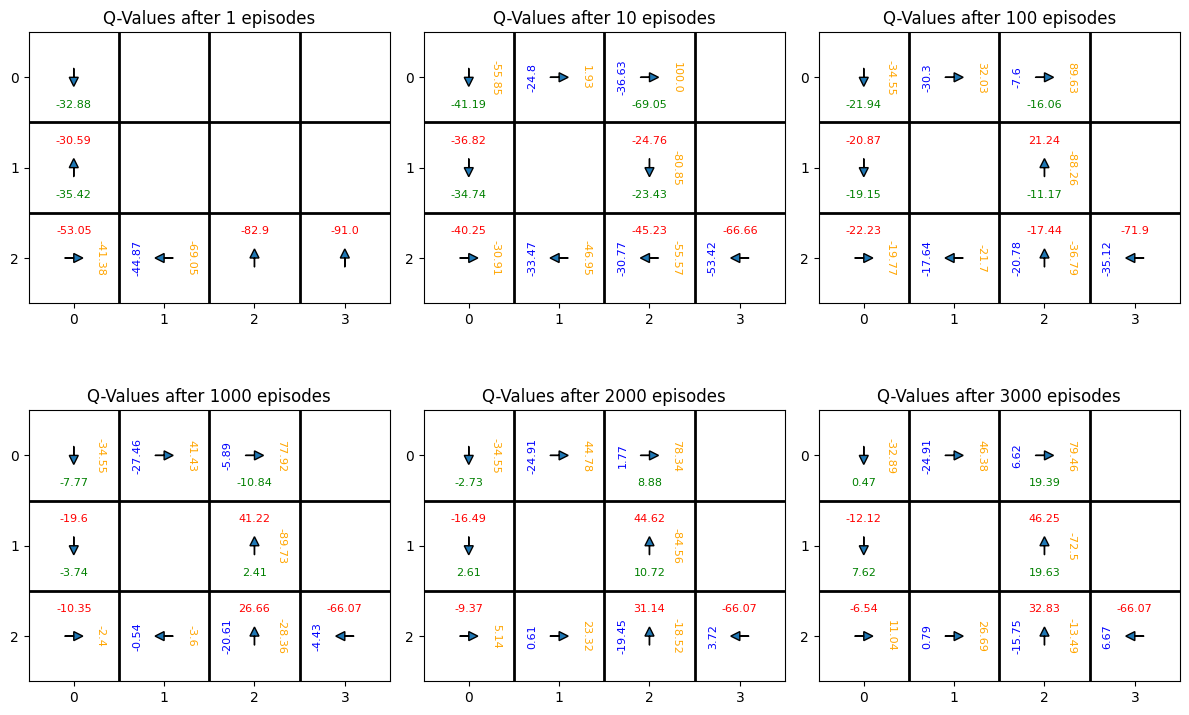

In [6]:
#visualize grid
returns,episodes_reward,avg_rpe,time_per_episode = visualize(world,episodes,epsilon_decay_rate,discount_factor)

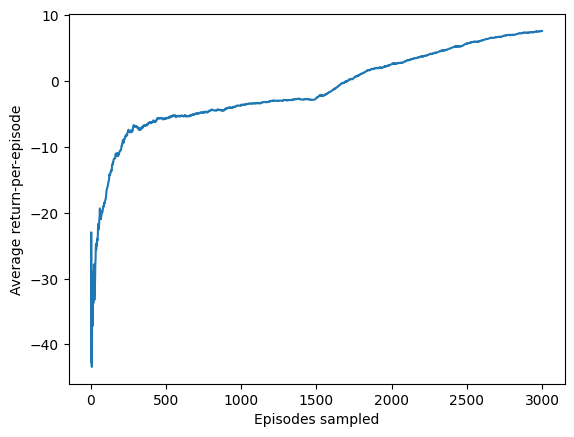

In [7]:
#visualize average return-per-episode in episodes-sampled
x = list(range(episodes[-1]+1)[1:])
y = avg_rpe
plt.plot(x,y)
plt.xlabel('Episodes sampled')
plt.ylabel('Average return-per-episode')
plt.show()

The policy (and therefore the agent's performance) improves with each new episode conducted. This is indicated by the increasing return. The average return-per-episode starts to plateau as the agent converges towards the optimal policy. The fluctations in the average return-per-episode indicate exploration (fluctations get less -> decrease in exploration, i.e. decrease in ϵ).

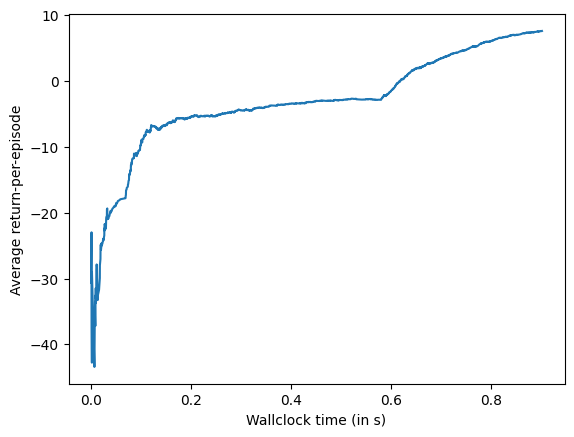

In [8]:
#visualize average return-per-episode in wallclock time
x = time_per_episode
y = avg_rpe
plt.plot(x,y)
plt.xlabel('Wallclock time (in s)')
plt.ylabel('Average return-per-episode')
plt.show()

This plot has a similar shape as the upper one, because as the number of episodes sampled increases, the amount of time taken to sample those episodes also increases.

Unlike the previous plot, which was only affected by the learning algorithm itself, this plot is additionally affected by external factors such as the computational resources.